<a href="https://colab.research.google.com/github/valec3/DataScienceProjects/blob/main/MODELOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Cargar Librerias**

In [38]:
# @title

# Manejo de datos
import json
import numpy as np
import pandas as pd
import ast
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer,r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from joblib import dump


In [64]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Cargar Datos**

In [122]:
df = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv')
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671


In [123]:
list(df.columns)

['channelGrouping',
 'date',
 'device',
 'fullVisitorId',
 'geoNetwork',
 'sessionId',
 'socialEngagementType',
 'totals',
 'trafficSource',
 'visitId',
 'visitNumber',
 'visitStartTime']

## **Preprocesamiento de datos**

In [124]:
# @title Funciones de ayuda

def get_info_df(df):
    # info df
    df_info = pd.DataFrame({'Nombre_Columna': df.columns,
                            'No_Nulls': df.notnull().sum().values,
                            'Tipo_Dato': df.dtypes.values},
                           index=range(1, len(df.columns)+1))
    return df_info
def json_to_df(df):
    # Json to DF
    columns_json = ['device', 'geoNetwork', 'totals', 'trafficSource']
    for column in columns_json:
        column_as_df = pd.json_normalize(df[column])
        col_df = pd.json_normalize(df[column].apply(json.loads))
        col_df.columns = [f"{column}.{subcolumn}" for subcolumn in col_df.columns]
        df = df.drop(column, axis=1).merge(col_df, right_index=True, left_index=True)
    return df

def count_null_values(df):
    result = pd.DataFrame(columns=['Column', 'Null_Count', 'Not_Null_Count', 'NaN_Count', 'Unique_Values'])

    for col in df.columns:
        null_count = df[col].isnull().sum()
        not_null_count = df[col].notnull().sum()
        nan_count = df[col].isna().sum()
        unique_values = df[col].nunique()
        result = result.append({'Column': col, 'Null_Count': null_count, 'Not_Null_Count': not_null_count, 'NaN_Count': nan_count, 'Unique_Values': unique_values}, ignore_index=True)
    single_unique_cols = result[result['Unique_Values'] == 1]['Column']
    for col in single_unique_cols:
        df = df.drop(columns=[col])
    return df

In [125]:
# @title Preprocesamiento
def preprocesamiento(df):
    # Json to DF
    columns_json = ['device', 'geoNetwork', 'totals', 'trafficSource']
    for column in columns_json:
        column_as_df = pd.json_normalize(df[column])
        col_df = pd.json_normalize(df[column].apply(json.loads))
        col_df.columns = [f"{subcolumn}" for subcolumn in col_df.columns]
        df = df.drop(column, axis=1).merge(col_df, right_index=True, left_index=True)
    # Casting
    cuant = ['bounces', 'hits','newVisits','pageviews', 'transactionRevenue']
    for columna in cuant:
        df[columna] = pd.to_numeric(df[columna], errors='coerce').fillna(0)
    df['bounces'] = df['bounces'].astype('int64')
    df['transactionRevenue'] = df['transactionRevenue'].astype('float64')
    df['newVisits'] = df['newVisits'].astype('int64')

    # FEATURE engineering
    # Reemplazar números por fechas
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

    # Crear nuevas variables a partir de 'date'
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['quarterMonth'] = df['date'].apply(lambda x: (x.month - 1) // 3 + 1)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    # Crear variable 'time_range' a partir de 'visitStartTime'
    df['time_range'] = pd.cut(df['visitStartTime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['madrugada', 'mañana', 'tarde', 'noche'], ordered=False).astype('object')
    # Ratio de Conversiones (Conversion Rate)
    df['conversion_rate'] = df['transactionRevenue'] / df['visitNumber']
    # Duración de la Sesión (Session Duration)
    df['session_duration'] = df['visitStartTime'].diff().dt.total_seconds()
    # Frecuencia de Visitas (Visit Frequency)
    visit_frequency = df.groupby('fullVisitorId')['visitNumber'].nunique()
    df['visit_frequency'] = df['fullVisitorId'].map(visit_frequency)
    # Interacción del Usuario (User Interaction)
    df['user_interaction'] = (df['bounces'] == 0).astype(int)
    # Eliminar atributos que no se utilizarán
    df.drop(['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitStartTime'], axis=1, inplace=True)

    columnas_conservar = ['channelGrouping', 'visitNumber', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'continent', 'subContinent', 'country',
       'region', 'metro', 'city', 'networkDomain', 'hits', 'pageviews',
       'bounces', 'newVisits', 'transactionRevenue', 'campaign', 'source',
       'medium', 'keyword', 'isTrueDirect', 'referralPath',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType',
       'adwordsClickInfo.isVideoAd', 'adContent', 'year', 'month',
       'quarterMonth', 'day', 'weekday', 'time_range', 'conversion_rate',
       'session_duration', 'visit_frequency', 'user_interaction']

    # Eliminar las columnas que no están en la lista de conservación
    df = df[columnas_conservar]
    # Aplicar LabelEncoder a variables categóricas

    # Reiniciar el índice
    df.reset_index(drop=True, inplace=True)
    return df



In [126]:
df=preprocesamiento(df)
# df=df.dropna()
df=count_null_values(df)
for columna in df.columns:
    frecuencias = df[columna].value_counts()
    print(f"Frecuencias de valores en la columna '{columna}':")
    print(frecuencias)
    print("\n")
get_info_df(df)

Frecuencias de valores en la columna 'channelGrouping':
Organic Search    5155
Social            3052
Direct            2011
Referral          1438
Paid Search        310
Affiliates         236
Display             77
(Other)              4
Name: channelGrouping, dtype: int64


Frecuencias de valores en la columna 'visitNumber':
1      9445
2      1277
3       532
4       286
5       172
6       107
7        78
8        63
9        59
10       47
11       40
12       30
13       19
14       16
16       16
17       14
18       12
15       12
20        8
19        6
22        5
21        4
24        3
27        3
26        3
25        2
195       1
57        1
70        1
178       1
58        1
181       1
23        1
29        1
42        1
30        1
180       1
36        1
176       1
38        1
28        1
35        1
34        1
189       1
32        1
191       1
190       1
194       1
193       1
44        1
Name: visitNumber, dtype: int64


Frecuencias de valores en la columna

,Nombre_Columna,No_Nulls,Tipo_Dato
1,channelGrouping,12283,object
2,visitNumber,12283,int64
3,browser,12283,object
4,operatingSystem,12283,object
5,isMobile,12283,bool
6,deviceCategory,12283,object
7,continent,12283,object
8,subContinent,12283,object
9,country,12283,object
10,region,12283,object


## **Visualizacion de datos**

In [148]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
# get_info_df(df)
df_vis = df.copy()

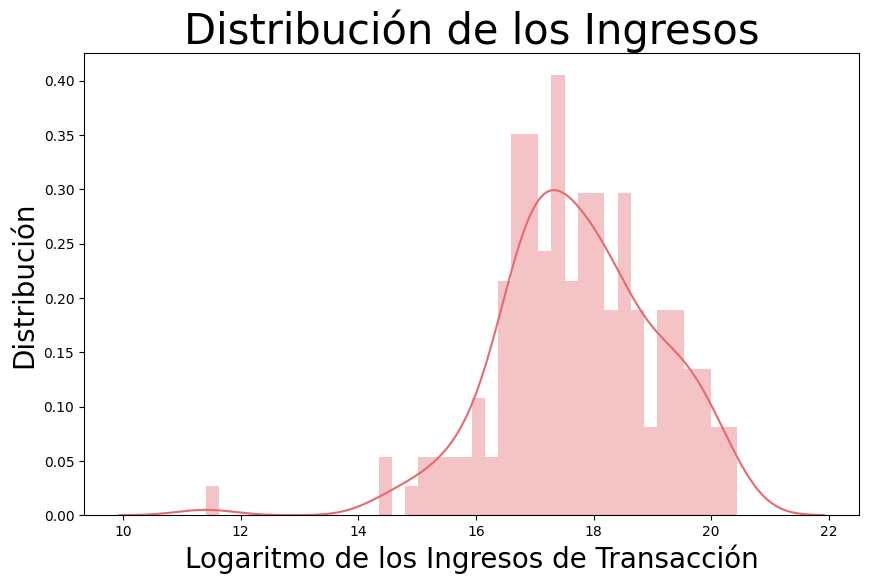

In [128]:
# @title Distribucion de ingresos
plt.figure(figsize=(10, 6))
plt.title('Distribución de los Ingresos', fontsize=30)
sns.distplot(np.log(df[df['transactionRevenue'] > 0]["transactionRevenue"]), bins=40, color='#e56b6f')
plt.ylabel('Distribución', fontsize=20)
plt.xlabel('Logaritmo de los Ingresos de Transacción', fontsize=20)
plt.show()

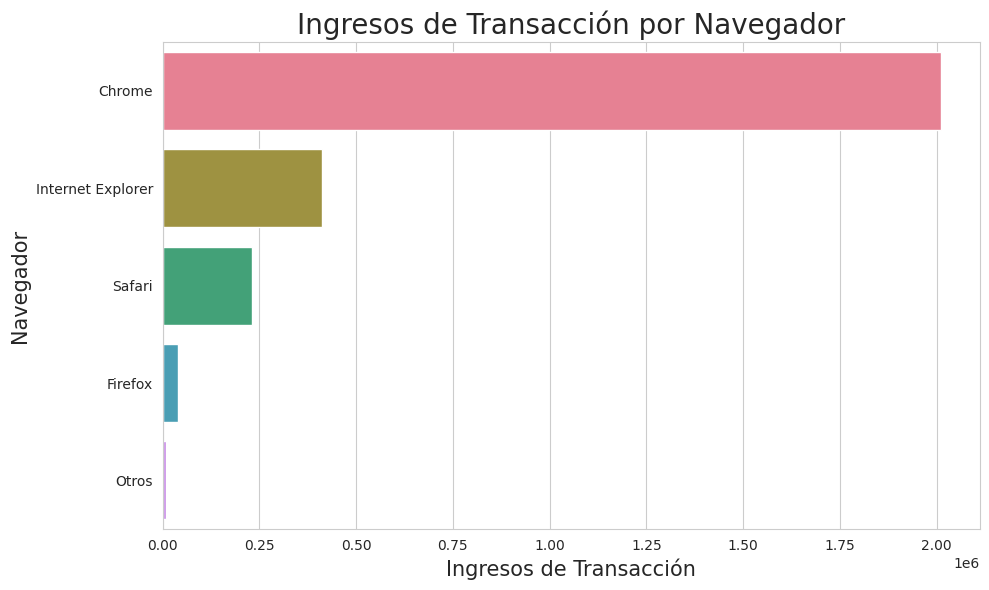

In [152]:
# @title Gráfico de barras de browser vs transactionRevenue
top_browsers = df['browser'].value_counts().nlargest(5).index.tolist()
browser_order = df_vis.groupby('browser')['transactionRevenue'].mean().sort_values(ascending=False).index
palette = sns.color_palette("husl", len(df['browser'].unique()))

df_vis['browser'] = df['browser'].apply(lambda x: x if x in top_browsers else 'Otros')
plt.figure(figsize=(10, 6))
plt.title('Ingresos de Transacción por Navegador', fontsize=20)
sns.barplot(x='transactionRevenue', y='browser', data=df, ci=None,palette=palette,order=browser_order)
plt.xlabel('Ingresos de Transacción', fontsize=15)
plt.ylabel('Navegador', fontsize=15)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

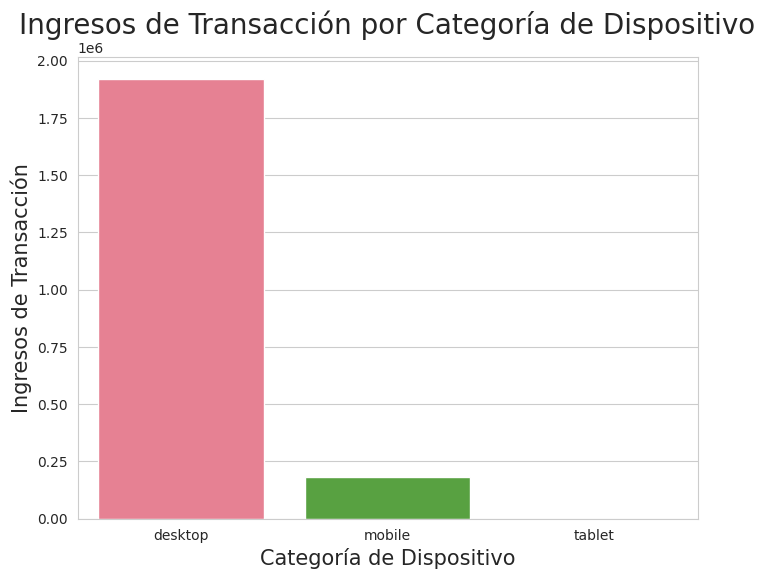

In [147]:
# @title Gráfico de barras de deviceCategory vs transactionRevenue
palette = sns.color_palette("husl", len(df['deviceCategory'].unique()))
plt.figure(figsize=(8, 6))
plt.title('Ingresos de Transacción por Categoría de Dispositivo', fontsize=20)
sns.barplot(x='deviceCategory', y='transactionRevenue', data=df, ci=None,palette=palette)
plt.xlabel('Categoría de Dispositivo', fontsize=15)
plt.ylabel('Ingresos de Transacción', fontsize=15)
plt.show()

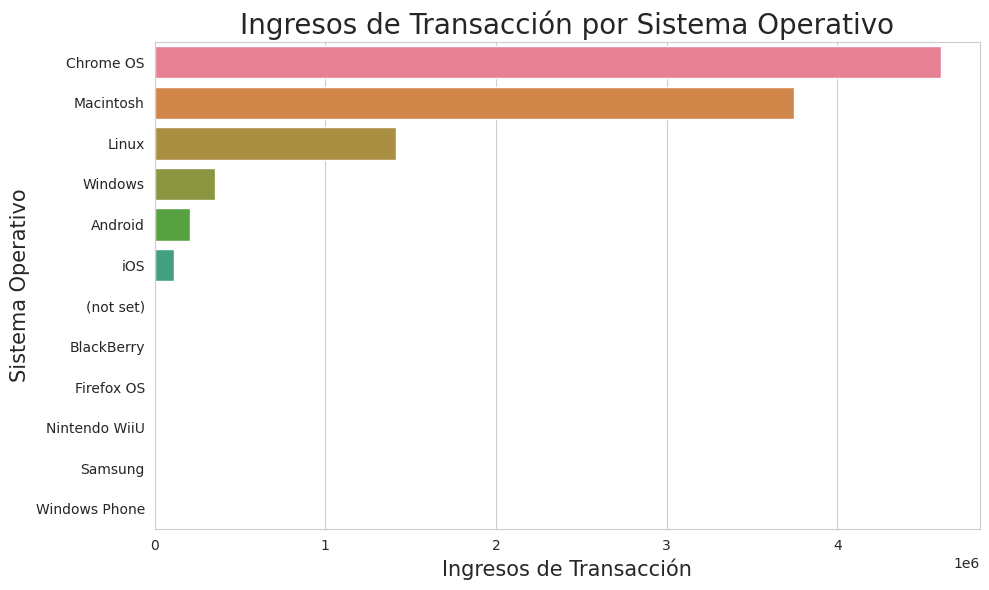

In [154]:
# @title Gráfico de barras de operatingSystem vs transactionRevenue
operatingSystem_order = df_vis.groupby('operatingSystem')['transactionRevenue'].mean().sort_values(ascending=False).index
palette = sns.color_palette("husl", len(df['operatingSystem'].unique()))

plt.figure(figsize=(10, 6))
plt.title('Ingresos de Transacción por Sistema Operativo', fontsize=20)
sns.barplot(x='transactionRevenue', y='operatingSystem', data=df_vis, ci=None, palette=palette, order=operatingSystem_order)
plt.xlabel('Ingresos de Transacción', fontsize=15)
plt.ylabel('Sistema Operativo', fontsize=15)
plt.tight_layout()
plt.show()

## **Entrenar Modelos**

In [ ]:
# DATOS PROCESADOS 2
# df = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/EDA Y PREPROCESAMIENTO/Traffic_Modelo.csv')

In [ ]:
# @title Managment revenue
df['transactionRevenue'] = df['transactionRevenue'].apply(lambda x: np.log1p(x))
df['transactionRevenue'].fillna(0, inplace=True)
# Aplicar LabelEncoder a variables categóricas
cualitativas = df.dtypes[df.dtypes == object].keys()
for columna in cualitativas:
    lbl = LabelEncoder()
    strings = list(df[columna].values.astype('str'))
    lbl.fit(strings)
    df[columna] = lbl.transform(strings)

In [8]:
X = df.drop('transactionRevenue', axis=1)
y = df['transactionRevenue']
# datos del csv
# test_size=0.2   random_state=41   -> RMSE =  6.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [9]:
# @title Construccion de los modelos

from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

models = {
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200),
    'Random Forest': RandomForestRegressor(max_depth=10, n_estimators=200),
    'Support Vector Machine': SVR(kernel='rbf', C=10, epsilon=0.5, gamma='auto'),
    'AdaBoost': AdaBoostRegressor(n_estimators=200, learning_rate=0.01),
    'AdaBoost': AdaBoostRegressor(n_estimators=200, learning_rate=0.01),
    'Extra Trees': ExtraTreesRegressor(n_estimators=200, max_depth=10)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append({'Modelo': name, 'MSE': mse, 'R^2': r2, 'MAE': mae, 'RMSE': rmse})


results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.34753e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,Modelo,MSE,R^2,MAE,RMSE
0,Gradient Boosting,0.024356,0.993857,0.011567,0.156064
1,Random Forest,0.040236,0.989851,0.015964,0.200590
2,Support Vector Machine,4.135143,-0.042985,0.845956,2.033505
3,AdaBoost,0.044048,0.988890,0.017247,0.209877
4,XGBoost,0.113710,0.971320,0.065110,0.337209
5,Extra Trees,0.031223,0.992125,0.013632,0.176699
6,K-Nearest Neighbors,4.580420,-0.155295,0.404628,2.140192
7,Ridge Regression,0.945431,0.761539,0.280703,0.972333
8,Lasso Regression,1.483735,0.625766,0.306759,1.218086
9,ElasticNet Regression,1.338519,0.662393,0.303423,1.156944


In [ ]:
# @title Validacion cruzado con el mejor modelo
modelo_gr = GradientBoostingRegressor(n_estimators=200)

puntuaciones = cross_val_score(modelo_gr, X, y, cv=5, scoring='neg_mean_squared_error')

rmse_scores = (-puntuaciones)**0.5

print("Puntuaciones de la validación cruzada (neg_mean_squared_error):", puntuaciones)
print("RMSE medio:", rmse_scores.mean())


Puntuaciones de la validación cruzada (neg_mean_squared_error): [-0.00904878 -0.00569531 -0.3249587  -0.01893478 -0.00564665]
RMSE medio: 0.19067834321753502


### Grafico de las metricas por modelo

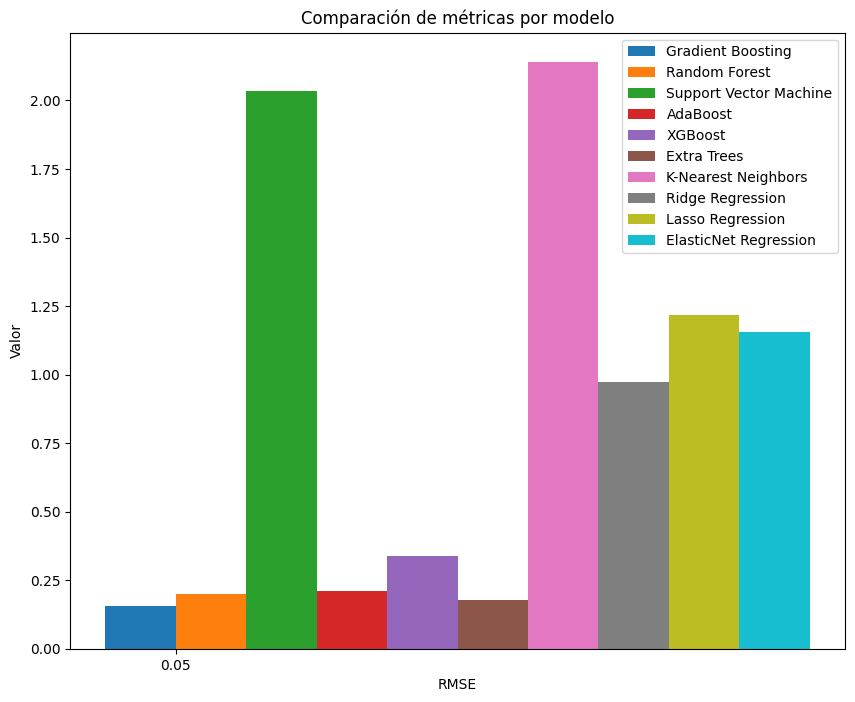

In [12]:
# @title Medidas

metricas = [ 'RMSE']
modelos = results_df['Modelo'].unique()

fig, ax = plt.subplots(figsize=(10, 8))
ancho_barra = 0.1
espacio_entre_barras = 0
indice = np.arange(len(metricas))

# Para cada modelo, graficar una barra para cada métrica
for i, modelo in enumerate(modelos):
    valores_metricas = results_df.loc[results_df['Modelo'] == modelo, metricas].values[0]
    ax.bar(indice + (ancho_barra + espacio_entre_barras) * i, valores_metricas, width=ancho_barra, label=modelo)

ax.set_xlabel('RMSE')
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas por modelo')
ax.set_xticks(indice + ancho_barra / 2)
# ax.set_xticklabels(metricas)
ax.legend()

plt.show()


### **Optimizar hiperparametros**

#### **SVM**

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

model = SVR(kernel='rbf')
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

best_model = SVR(**best_params)
best_model.fit(X_train, y_train)


Mejores hiperparámetros: {'C': 10, 'epsilon': 0.2, 'gamma': 'scale'}


SVR(C=10, epsilon=0.2)

#### **Gradient Boosting Regressor**

In [ ]:


param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]
}

model_gb = GradientBoostingRegressor()

grid_search_gb = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_
print("Mejores hiperparámetros para Gradient Boosting:", best_params_gb)

best_model_gb = GradientBoostingRegressor(**best_params_gb)
best_model_gb.fit(X_train, y_train)


Mejores hiperparámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


GradientBoostingRegressor(n_estimators=200)

#### **Random Forest**

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

model_rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, scoring=scorer)
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
print("Mejores hiperparámetros para Random Forest:", best_params_rf)

best_model_rf = RandomForestRegressor(**best_params_rf)
best_model_rf.fit(X_train, y_train)


Mejores hiperparámetros para Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=50)

In [ ]:
indices_aleatorios = np.random.choice(len(X_test), size=10, replace=False)
X_test_10 = X_test.iloc[indices_aleatorios]
y_test_10 = y_test.iloc[indices_aleatorios]

y_pred = models['Gradient Boosting'].predict(X_test_10)

df_resultados = pd.DataFrame({
    'Real_Y': y_test_10,
    'Y_Estimado': y_pred
})

print(df_resultados)

       Real_Y  Y_Estimado
8721      0.0   -0.000018
10769     0.0   -0.000018
6903      0.0   -0.000018
6894      0.0   -0.000018
2601      0.0   -0.001722
7346      0.0   -0.000018
3758      0.0   -0.000018
10529     0.0   -0.000018
6808      0.0   -0.000018
8527      0.0   -0.000018


### **Guardar modelo**

In [ ]:
modelo = models['Gradient Boosting']
dump(modelo, 'model.joblib')

['model.joblib']

## **Pruebas del modelo**

In [ ]:
df_traffic = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_test.csv', dtype={'date':object,'fullVisitorId':object,'visitId':object})

In [ ]:
df_traffic.info()

In [ ]:
# @title
def convert_dict_to_json_str(value):
    return json.dumps(value)

def reprocesamiento(df_traffic):
    # Define las columnas que están en formato JSON
    diccionario = ['device', 'geoNetwork', 'trafficSource', 'totals']

    # Itera sobre las columnas JSON
    for column in diccionario:
        # Verifica si los datos ya son un diccionario
        if isinstance(df_traffic[column][0], str):
            # Si no, convierte los datos JSON a un diccionario de Python
            df_traffic[column] = df_traffic[column].apply(json.loads)

        # Extrae las claves de todos los elementos del diccionario
        all_keys = set()
        for row in df_traffic[column]:
            if row is not None:
                all_keys.update(row.keys())

        # Para cada clave, crea una nueva columna en el DataFrame
        for key in all_keys:
            df_traffic[key] = df_traffic[column].apply(lambda x: x.get(key, None))

        # Elimina la columna original en formato JSON
        df_traffic.drop(column, axis=1, inplace=True)


    # Reemplazar textos por números
    cuant = ['bounces', 'hits','newVisits','pageviews', 'transactionRevenue']
    for columna in cuant:
       df_traffic[columna] = pd.to_numeric(df_traffic[columna], errors='coerce').fillna(0)

    # Convertir la columna 'bounces' a tipo int64
    df_traffic['bounces'] = df_traffic['bounces'].astype('int64')

    # Convertir la columna 'transactionRevenue' a tipo float
    df_traffic['transactionRevenue'] = df_traffic['transactionRevenue'].astype('float64')

    # Convertir la columna 'newVisits' a tipo float
    df_traffic['newVisits'] = df_traffic['newVisits'].astype('int64')

    # Dividir transactionRevenue por 1000000
    if 'transactionRevenue' in df_traffic.columns:
    # Verificar si los valores son números antes de la división
     df_traffic['transactionRevenue'] = df_traffic['transactionRevenue'].apply(lambda x: x / 1000000 if pd.notnull(x) and isinstance(x, (int, float)) else x)
     #Reemplaza valores nulos con ceros.
     df_traffic['transactionRevenue'].fillna(0, inplace=True)

    # Reemplazar números por fechas
    df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y%m%d')
    df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')

    #Conservar solo las columnas mencionadas
    columnas_conservar = [
        'channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'referralPath', 'city', 'metro', 'visitNumber', 'visitStartTime',
        'browser', 'operatingSystem', 'isMobile', 'deviceCategory',
       'campaign', 'source', 'medium', 'hits', 'pageviews', 'bounces', 'newVisits', 'transactionRevenue'
         ]

    # Eliminar las columnas que no están en la lista de conservación
    columnas_a_eliminar = [col for col in df_traffic.columns if col not in columnas_conservar]
    df_traffic = df_traffic.drop(columns=columnas_a_eliminar)

    # Eliminar duplicados y columnas que tienen el mismo número o cadena de texto en todas sus filas
    for col in df_traffic.columns:
     if df_traffic[columna].nunique() == 1:
        df_traffic.drop(columna, axis=1, inplace=True)

    return df_traffic

df_traffic = reprocesamiento(df_traffic)
df_traffic.sample(5)

def feature_engineering():
  global df_traffic

  # Crear nuevas variables a partir de 'date'
  df_traffic['year'] = df_traffic['date'].apply(lambda x: x.year)
  df_traffic['month'] = df_traffic['date'].apply(lambda x: x.month)
  df_traffic['quarterMonth'] = df_traffic['date'].apply(lambda x: (x.month - 1) // 3 + 1)
  df_traffic['day'] = df_traffic['date'].apply(lambda x: x.day)
  df_traffic['weekday'] = df_traffic['date'].apply(lambda x: x.weekday())

  # Crear variable 'time_range' a partir de 'visitStartTime'
  df_traffic['time_range'] = pd.cut(df_traffic['visitStartTime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['madrugada', 'mañana', 'tarde', 'noche'], ordered=False).astype('object')

  # Ratio de Conversiones (Conversion Rate)
  df_traffic['conversion_rate'] = df_traffic['transactionRevenue'] / df_traffic['visitNumber']

  # Duración de la Sesión (Session Duration)
  df_traffic['session_duration'] = df_traffic['visitStartTime'].diff().dt.total_seconds()

  # Frecuencia de Visitas (Visit Frequency)
  visit_frequency = df_traffic.groupby('fullVisitorId')['visitNumber'].nunique()
  df_traffic['visit_frequency'] = df_traffic['fullVisitorId'].map(visit_frequency)


  # Interacción del Usuario (User Interaction)
  df_traffic['user_interaction'] = (df_traffic['bounces'] == 0).astype(int)

  # Eliminar atributos que no se utilizarán
  df_traffic.drop(['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitStartTime'], axis=1, inplace=True)

  # Aplicar LabelEncoder a variables categóricas
  cualitativas = df_traffic.dtypes[df_traffic.dtypes == object].keys()
  for columna in cualitativas:
      lbl = LabelEncoder()
      strings = list(df_traffic[columna].values.astype('str'))
      lbl.fit(strings)
      df_traffic[columna] = lbl.transform(strings)

  # Reiniciar el índice
  df_traffic.reset_index(drop=True, inplace=True)


feature_engineering()

df_traffic.sample(5)


,channelGrouping,visitNumber,operatingSystem,browser,deviceCategory,isMobile,city,metro,source,referralPath,...,year,month,quarterMonth,day,weekday,time_range,conversion_rate,session_duration,visit_frequency,user_interaction
274,3,1,8,12,1,True,92,22,11,59,...,2017,6,2,25,6,1,0.0,-20307.0,1,1
560,6,9,1,3,1,True,92,22,22,46,...,2017,1,1,7,5,4,0.0,-49168.0,3,0
549,3,4,5,3,0,False,92,22,11,59,...,2017,1,1,7,5,1,0.0,-37422.0,3,1
285,0,1,4,3,0,False,10,0,1,59,...,2016,8,3,18,3,1,0.0,-51108.0,1,1
93,3,1,5,3,0,False,58,12,11,59,...,2017,1,1,14,5,0,0.0,12082298.0,1,0


In [ ]:
print(df.columns)
print("#"*15)
print(df_traffic.columns)

Index(['channelGrouping', 'visitNumber', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'continent', 'subContinent', 'country',
       'region', 'metro', 'city', 'networkDomain', 'hits', 'pageviews',
       'bounces', 'newVisits', 'transactionRevenue', 'campaign', 'source',
       'medium', 'keyword', 'isTrueDirect', 'referralPath',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType',
       'adwordsClickInfo.isVideoAd', 'adContent', 'year', 'month',
       'quarterMonth', 'day', 'weekday', 'time_range', 'conversion_rate',
       'session_duration', 'visit_frequency', 'user_interaction'],
      dtype='object')
###############
Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')


In [ ]:
df_traffic=preprocesamiento(df_traffic)
df_traffic = df_traffic[df.columns]
df_traffic = df_traffic.dropna()
X = df_traffic.drop('transactionRevenue',axis=1)

# X['clasificacion'] = modelo_clasificacion.predict(X)
y = df_traffic.transactionRevenue.copy()
modelo = models['Gradient Boosting']
predictions = modelo.predict(X)
predictions[predictions < 1] = 0

#Genera algunas métricas de evaluación de los pronosticos
r2 = r2_score(y, predictions)*100
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f"R-cuadrado (R²): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

R-cuadrado (R²): 99.89632803786246
Error cuadrático medio (MSE): 0.005136200034803915
Raíz del error cuadrático medio (RMSE): 0.07166728706183816


In [ ]:
#Ejemplos de los pronósticos
df_resultados = pd.DataFrame({
    'transactionRevenue': y,
    'predictions': predictions
})
df_resultados[df_resultados.transactionRevenue>0].sample(10)

,transactionRevenue,predictions
238,17.118360,17.022541
820,18.792037,18.969720
657,17.117992,17.580881
220,15.893701,17.906616
939,20.008282,19.922461
192,19.412264,19.499280
949,17.043941,17.526159
166,17.943451,17.868742
654,18.315209,17.790124
655,16.992314,17.029699
